<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=400></center>

<h6><center>Introduction to Machine Learning</center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center>TD 3: Dimentionality Reduction (Correction)</center>
<hr style=" border:none; height:3px;">
</h1>

__Teachers__: Myriam Tami, Gianluca Quercini, Yassine Ouali

# Your turn!

Now it's time to test out these approaches, i.e.,

+ Best/Forward/Backward selection and evaluation methods (adjusted training error, validation set, cross validation)
+ PCA (tunning of $M$ value, visualization and interpretation of the plots

on another dataset: `housing` (the dataset used during the lab 2).


# Let's start a proposition of correction

First we import the modules that are commonly used for performing subset selection in combination with Scikit-learn.
In order to run this notebook, you'll need to install Python 3.5 or later, as well as Scikit-learn 0.20 or later. Also, we import the libraries and `housing` dataset.


## Setup


In [1]:
# !pip install statsmodels

In [2]:
# !pip install chart_studio

     |████████████████████████████████| 71kB 1.1MB/s eta 0:00:01
     |████████████████████████████████| 13.1MB 906kB/s eta 0:00:01
  Stored in directory: /Users/lastaw/Library/Caches/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# numpy arrays are used to .
import numpy as np

# pandas is used to manipulate tabular data.
import pandas as pd

# statsmodels provides classes and functions for the estimation of many different statistical models.
import statsmodels.api as sm

# itertools implements a number of iterator building blocks for efficient looping.
import itertools

# time provides various time-related functions
import time

# Matplotlib is used to plot graphs
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Style options for plots.
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Saves a figure to a file
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join("./figs", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## For PCA part
#################
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error

# Some libraries for PCA visualization
import seaborn as sns 
#Make Plotly figure
import chart_studio.plotly as py
# Be aware, plotly may be installed using pip on your shell:
# conda install -c plotly chart-studio
import plotly.graph_objs as go


We're going to download `housing` dataset containing California census data. Remember, this dataset contains one row per census district. A district is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (population of 600 to 3,000 people).

Given this dataset, our goal is: 
+ to apply dimensionality reduction approaches 
+ to predict the `median house value` in a given district

In [4]:

# Load data Colab version:

import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
if not os.path.isfile(os.path.join(HOUSING_PATH, "housing.csv")):
    fetch_housing_data()

# Load data
csv_path = os.path.join(HOUSING_PATH, "housing.csv")
housing_df = pd.read_csv(csv_path, index_col = False)
housing_df.head()

#housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Subset Selection Approaches

## Best Subset Selection


First of all, we have to identify the missing observations.

In [5]:
housing_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
print("Number of null values:\n", housing_df.isnull().sum())

Number of null values:
 longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


In [11]:
print("Number of null values:", housing_df["total_bedrooms"].isnull().sum())

Number of null values: 207


We see that `total_bedrooms` is missing for 207 districts. The `dropna()` function removes all of the rows that have missing values in any feature:

In [61]:
# Print the dimensions of the original housing data
print("Dimensions of original data:", housing_df.shape)

# Drop any rows where at least one element is missing
housing_df_clean = housing_df.dropna()

# Print the dimensions of the modified housing data
print("Dimensions of modified data:", housing_df_clean.shape)

# One last check: should return 0
print("Number of null values:", housing_df_clean["total_bedrooms"].isnull().sum())

Dimensions of original data: (20640, 10)
Dimensions of modified data: (20433, 10)
Number of null values: 0


Some of our features are categorical, so we'll want to clean those up as well. We'll ask `pandas` to generate dummy variables for them, separate out the target variable, and stick everything back together again:

In [62]:
dummies = pd.get_dummies(housing_df_clean[['ocean_proximity']])
dummies.head()

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


In [63]:
# Get dummy variables
dummies = pd.get_dummies(housing_df_clean[['ocean_proximity']])

# Extract the target variable
y = housing_df_clean.median_house_value

# Drop the column with the independent and target variable (median_house_value), and columns for which we created dummy variables
X_ = housing_df_clean.drop(['median_house_value', 'ocean_proximity'], axis=1).astype('float64')

# Define the feature set X, our matrix data
X = pd.concat([X_, dummies], axis=1)

X.shape

(20433, 13)

We can perform best subset selection by identifying the best model that contains a given number of features, where best is quantified using **RSS**. We'll define a helper function to outputs the best set of features for each model size:

In [64]:
def processSubset(feature_set):
    # Fit OLS (Ordinary Least Squares) model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [65]:
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model



This returns a `DataFrame` containing the best model that we generated, along with some extra information about the model. Now we want to call that function for each number of features `k`:

In [66]:
# It might take a while... Please be patient. 
# As long as the star to the left of the cell is displayed do not run again the cell.

models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,10):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")


/Users/lastaw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  


Processed 13 models on 1 predictors in 0.05989575386047363 seconds.
Processed 78 models on 2 predictors in 0.42952799797058105 seconds.
Processed 286 models on 3 predictors in 1.618945837020874 seconds.
Processed 715 models on 4 predictors in 5.104722738265991 seconds.
Processed 1287 models on 5 predictors in 10.56454586982727 seconds.
Processed 1716 models on 6 predictors in 16.810720920562744 seconds.
Processed 1716 models on 7 predictors in 23.070045948028564 seconds.
Processed 1287 models on 8 predictors in 17.9496910572052 seconds.
Processed 715 models on 9 predictors in 10.299835920333862 seconds.
Total elapsed time: 90.59270668029785 seconds.


Now we have one big `DataFrame` that contains the best models we've generated along with their `RSS`:

In [67]:
models_best

,RSS,model
1,1.512504e+14,<statsmodels.regression.linear_model.Regressio...
2,1.337039e+14,<statsmodels.regression.linear_model.Regressio...
3,1.131256e+14,<statsmodels.regression.linear_model.Regressio...
4,1.091319e+14,<statsmodels.regression.linear_model.Regressio...
5,1.022380e+14,<statsmodels.regression.linear_model.Regressio...
6,1.006910e+14,<statsmodels.regression.linear_model.Regressio...
7,1.003378e+14,<statsmodels.regression.linear_model.Regressio...
8,9.995819e+13,<statsmodels.regression.linear_model.Regressio...
9,9.963799e+13,<statsmodels.regression.linear_model.Regressio...


If we want to access the details of each model, no problem! We can get a full rundown of a single model using the `summary()` function:

In [68]:
print(models_best.loc[2, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:     median_house_value   R-squared (uncentered):                   0.883
Model:                            OLS   Adj. R-squared (uncentered):              0.883
Method:                 Least Squares   F-statistic:                          7.739e+04
Date:                Sun, 18 Oct 2020   Prob (F-statistic):                        0.00
Time:                        19:47:57   Log-Likelihood:                     -2.5990e+05
No. Observations:               20433   AIC:                                  5.198e+05
Df Residuals:                   20431   BIC:                                  5.198e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

This output indicates that the best two-feature model contains only `housing_median_age` and `median_income `. 

In [ ]:
# Show the best 9-feature model (there's actually only one)
print(getBest(9)["model"].summary())

Rather than letting the results of our call to the `summary()` function print to the screen, we can access just the parts we need using the model's attributes. For example, if we want the $R^2$ value:

In [ ]:
models_best.loc[2, "model"].rsquared


In addition to the verbose output we get when we print the summary to the screen, fitting the OLS (Ordinary Least Squares) also produced many other useful statistics such as **adjusted $R^2$**, **AIC**, and **BIC**. We can examine these to try to select the best overall model. Let's start by looking at $R^2$ across all our models:

In [ ]:
# Gets the second element from each row ('model') and pulls out its rsquared attribute
models_best.apply(lambda row: row[1].rsquared, axis=1)

As expected, the $R^2$ statistic increases monotonically as more features are included.

Plotting RSS, adjusted $R^2$, AIC, and BIC for all of the models at once will help us decide which model to select.

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the lowest RSS value.
# The argmax() function can be used to identify the location of the minimum point of a vector.
rss = models_best["RSS"]
plt.plot(rss)
plt.plot(rss.argmin(), rss.min(), "or")
plt.xlabel('# Features')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector.

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Features')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Features')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Features')
plt.ylabel('BIC')

We see that they all agree that a model with 8 predictors is sufficient.

## Forward and Backward Stepwise Selection

We can also use a similar approach to perform forward stepwise or backward stepwise selection, using a slight modification of the functions we defined above:

In [ ]:
def forward(features):

    # Pull out features we still need to process
    remaining_features = [d for d in X.columns if d not in features]
    
    tic = time.time()
    
    results = []
    
    for d in remaining_features:
        results.append(processSubset(features+[d]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(features)+1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

Now let's see how much faster it runs.

In [ ]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
features = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(features)
    features = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")



That's a lot better than previously. Let's take a look:

In [ ]:
print(models_fwd.loc[1, "model"].summary())
print(models_fwd.loc[2, "model"].summary())

We see that using forward stepwise selection, the best one-feaure model contains only `median_income`, and the best two-feature model additionally includes `housing_median_age`. Let's see how the models stack up against best subset selection:

In [ ]:
print(models_best.loc[4, "model"].summary())
print(models_fwd.loc[4, "model"].summary())

For this data, the best one-feature through four-feature models are each identical for best subset and forward selection (but it's not the case for six-feature models).

## Backward Selection

Not much has to change to implement backward selection... just looping through the features in reverse.

In [ ]:
def backward(features):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(features, len(features)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(features)-1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model


In [ ]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
features = X.columns

while(len(features) > 1):  
    models_bwd.loc[len(features)-1] = backward(features)
    features = models_bwd.loc[len(features)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

For this data, the best one-feature through four-feature models are each identical for best subset and forward selection. However, the best seven-feature models identified by forward stepwise selection, backward stepwise selection, and best subset selection are different:

In [ ]:
print("------------")
print("Best Subset:")
print("------------")
print(models_best.loc[4, "model"].params)

In [ ]:
print("-----------------")
print("Foward Selection:")
print("-----------------")
print(models_fwd.loc[4, "model"].params)

In [ ]:


print("-------------------")
print("Backward Selection:")
print("-------------------")
print(models_bwd.loc[4, "model"].params)



# Choosing among models using Validation Set approach and Cross-Validation


We just saw that it is possible to choose among a set of models of different sizes using AIC, BIC, and adjusted $R^2
$. We will now consider how to do this using the validation set and cross-validation approaches.

## Model selection using Validation Set approach

In order for the $validation set approach$ to yield accurate estimates of the test error, we must use only the training observations to perform all aspects of model-fitting — including variable selection. Therefore, the determination of which model of a given size is best must be made using only the training observations. This point is subtle but important. If the full data set is used to perform the best subset selection step, the validation set errors and cross-validation errors that we obtain will not be accurate estimates of the test error.

In order to use the $validation set$ approach, we begin by splitting the observations into a $training set$ and a $test set$. We do this by creating a random vector, `train`, of elements equal to `TRUE` if the corresponding observation is in the training set, and `FALSE` otherwise. The vector `test` has a `TRUE` if the observation is in the test set, and a `FALSE` otherwise. Note the `np.invert()` in the command to create `test` causes `TRUE`s to be switched to `FALSE`s and vice versa. We also set a random seed so that the user will obtain the same training set/test set split.


In [47]:
np.random.seed(seed=12)
train = np.random.choice([True, False], size = len(y), replace = True)
test = np.invert(train)

In [48]:
test.sum()

10175

We'll define our helper function to outputs the best set of features for each model size like we did in previous part of the lab. Note that we'll need to modify this to take in both test and training sets, because we want the returned error to be the **test error**:

In [25]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
    # Fit OLS model on feature_set (from train)
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    # Compute RSS using model predictions on feature_set (from test) and the true test value of the target
    RSS = ((regr.predict(X_test[list(feature_set)]) - y_test) ** 2).sum()
    return {"model":regr, "RSS":RSS}

And our update function to perform forward selection in the context of validation set approach:

In [31]:
def forwardCV(features, X_train, y_train, X_test, y_test):
    
    results = []

    # Pull out features we still need to process
    remaining_features = [d for d in X_train.columns if d not in features]
    
    
    for d in remaining_features:
        results.append(processSubset(features+[d], X_train, y_train, X_test, y_test))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].idxmin()]
        
    # Return the best model, along with some other useful information about the model
    return best_model

Now, we'll call our `forwardCV()` function on the training set in order to perform forward selection for all model sizes:

In [32]:
models_train = pd.DataFrame(columns=["RSS", "model"])

features = []

for i in range(1,len(X.columns)+1):    
    #models_train.loc[i] = forwardCV(features, X[train], y[train]["Salary"], X[test], y[test]["Salary"])
    models_train.loc[i] = forwardCV(features, X[train], y[train], X[test], y[test])
    features = models_train.loc[i]["model"].model.exog_names

Now let's plot the errors, and find the model that minimizes it:

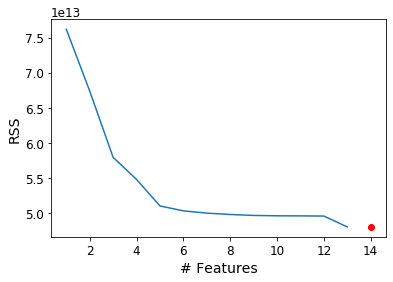

In [39]:
plt.plot(models_train["RSS"])
plt.xlabel('# Features')
plt.ylabel('RSS')
plt.plot(models_train["RSS"].idxmin()+1, models_train["RSS"].min(), "or")
# We use "models_train["RSS"].idxmin()+1" because python start counting at zero

#print(models_train["RSS"].idxmin())
#print(models_train["RSS"].idxmin()+1)
#print(models_train["RSS"].min())
#print(models_train["RSS"])

We find that the best model according to the validation set approach is the one that contains 13 features, i.e., all the features. This result it's mainly due to this small dataset `housing`. But you can try to apply these approaches o a bigest one. You can choose one from the UCI machine learning repository (http://archive.ics.uci.edu/ml/datasets.html). Download a dataset, and try to determine the optimal set of parameters to use to model it! However, here, we observe that after 5 features the RSS tends to stagnate.

Then, we can perform best subset selection on the full dataset and select the best 5-feature model. It is important that we make use of the full data set in order to obtain more accurate coefficient estimates. We perform this selection on the full data set and select the best 5-feature model, rather than simply using the features that we obtained from the training set, because the best 5-feature model on the full data set may differ from the corresponding model on the training set.


In [40]:
models_test = pd.DataFrame(columns=["RSS", "model"])

features = []

for i in range(1,6):    
    models_test.loc[i] = forwardCV(features, X[test], y[test], X[test], y[test])
    features = models_test.loc[i]["model"].model.exog_names

In fact, we see that the best 5-feature model on the full data set has a different set of features than the best 10-feature model on the training set:

In [49]:
print(models_train.loc[5, "model"].model.exog_names)
print(models_test.loc[5, "model"].model.exog_names)

['median_income', 'housing_median_age', 'ocean_proximity_INLAND', 'total_bedrooms', 'population']
['median_income', 'housing_median_age', 'ocean_proximity_INLAND', 'total_bedrooms', 'population']


In [52]:
models_train

,RSS,model
1,7.619048e+13,<statsmodels.regression.linear_model.Regressio...
2,6.737484e+13,<statsmodels.regression.linear_model.Regressio...
3,5.791393e+13,<statsmodels.regression.linear_model.Regressio...
4,5.476734e+13,<statsmodels.regression.linear_model.Regressio...
5,5.098488e+13,<statsmodels.regression.linear_model.Regressio...
6,5.028211e+13,<statsmodels.regression.linear_model.Regressio...
7,4.995889e+13,<statsmodels.regression.linear_model.Regressio...
8,4.976555e+13,<statsmodels.regression.linear_model.Regressio...
9,4.962915e+13,<statsmodels.regression.linear_model.Regressio...
10,4.957787e+13,<statsmodels.regression.linear_model.Regressio...


## Model selection using Cross-Validation approach

Now let's try to choose among the models of different sizes using cross-validation. This approach is somewhat involved, as we must perform forward selection within each of the `K` training sets. Despite this, we see that with its clever subsetting syntax, `Python` makes this job quite easy. First, we create a vector that assigns each observation to one of `K=10` folds, and we create a `DataFrame` in which we will store the results:

In [50]:
# Number of folds
K = 10
np.random.seed(seed=1)
folds = np.random.choice(K, size = len(y), replace = True)

# Create a DataFrame to store the results of our upcoming calculations
cv_errors = pd.DataFrame(columns=range(1,K+1), index=range(1,14))#Here we have 13 features (not 19)
cv_errors = cv_errors.fillna(0)

In [51]:
cv_errors

,1,2,3,4,5,6,7,8,9,10
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0


Now let's write a for loop that performs cross-validation. In the $k$th fold, the elements of folds that equal $k$ are in the test set, and the remainder are in the training set. We make our predictions for each model size, compute the test errors on the appropriate subset, and store them in the appropriate slot in the matrix cv_errors.

In [53]:
models_cv = pd.DataFrame(columns=["RSS", "model"])
    
# Outer loop iterates over all folds
for k in range(1,K+1):

    # Reset features
    features = []
    
    # Inner loop iterates over each size i
    for i in range(1,len(X.columns)+1):    
    
        # The perform forward selection on the full dataset minus the kth fold, test on kth fold
        models_cv.loc[i] = forwardCV(features, X[folds != (k-1)], y[folds != (k-1)], X[folds == (k-1)], y[folds == (k-1)])
        
        # Save the cross-validated error for this fold
        cv_errors[k][i] = models_cv.loc[i]["RSS"]

        # Extract the features
        features = models_cv.loc[i]["model"].model.exog_names
        

In [54]:

cv_errors

,1,2,3,4,5,6,7,8,9,10
1,15155244679093,14650290643305,15401419764182,13422989818674,15287208334089,16218928999346,15661289107818,14369384096750,15553421838793,15550462491783
2,13507910066955,13168724232056,13539120610649,11839301697897,13416208974727,14126852438009,13789727936241,12623913524834,13616349795440,14100171399070
3,11755945622920,11072264105838,11496423758439,10195130071971,11696897301738,12083935733817,12011078565483,10776971854711,11553389038817,12106523855451
4,11047917558986,10642455871680,10892571755796,9652343282940,11267781337994,11569019573412,11319296348559,10194508613302,10986719631076,11605005324161
5,10354312092352,9902075755519,10205477049001,8922489572119,10689659972061,10986318572437,10580081541367,9537434511037,10218770684840,10977072477487
6,10090811762906,9752757095451,10095583038099,8792834019486,10541472274110,10788269310230,10317123956005,9459125145801,9989372667606,10810137747793
7,9979330524847,9683928266610,10047598294428,8674416908277,10498303879296,10767162346859,10253939572780,9425791654152,9832960624168,10733860169589
8,9944841987942,9645589415593,10005989734954,8625682357156,10461454214862,10767313925955,10219450190399,9414734708073,9809390232635,10681964958506
9,9925837198121,9630195436980,9985310711380,8611962774759,10431413137253,10770818235420,10219140719664,9414178573859,9791722930644,10626881145727
10,9923093893345,9612974186850,9986257192239,8600852811307,10422813455756,10829198828826,10218866589025,9415055574697,9782304357876,10587884130751


This has filled up the `cv_errors` DataFrame such that the $(i,k)^{th}$ element corresponds to the test `MSE` for the $k$th cross-validation fold for the best $i$-feature model. We can then use the apply() function to take the mean over the columns of this matrix. This will give us a vector for which the $i$th element is the cross-validation error for the $i$-variable model.

1     1.512706e+13
2     1.337283e+13
3     1.147486e+13
4     1.091776e+13
5     1.023737e+13
6     1.006375e+13
7     9.989729e+12
8     9.957641e+12
9     9.940746e+12
10    9.937930e+12
11    9.946487e+12
12    9.871233e+12
13    9.656334e+12
dtype: float64


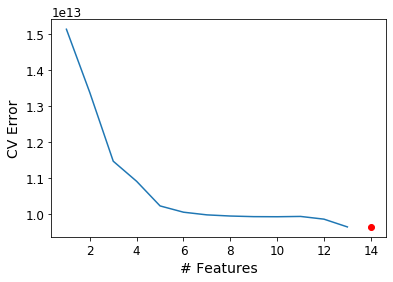

In [56]:
cv_mean = cv_errors.apply(np.mean, axis=1)
print(cv_mean)

plt.plot(cv_mean)
plt.xlabel('# Features')
plt.ylabel('CV Error')
plt.plot(cv_mean.idxmin()+1, cv_mean.min(), "or")

We see that cross-validation selects a 13-feature model. However, to continue the lab, we will choose the value of $5$ features (after this value the error tends to stagnate). Now let's go back to our results on the full data set in order to obtain the 5-feature model.

In [57]:
print(models_cv.loc[5, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:     median_house_value   R-squared (uncentered):                   0.912
Model:                            OLS   Adj. R-squared (uncentered):              0.912
Method:                 Least Squares   F-statistic:                          3.800e+04
Date:                Sun, 18 Oct 2020   Prob (F-statistic):                        0.00
Time:                        19:42:04   Log-Likelihood:                     -2.3133e+05
No. Observations:               18386   AIC:                                  4.627e+05
Df Residuals:                   18381   BIC:                                  4.627e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

For comparison, let's also take a look at the statistics from last lab's part:

/Users/lastaw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  # This is added back by InteractiveShellApp.init_path()
/Users/lastaw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/Users/lastaw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' w

Text(0, 0.5, 'BIC')

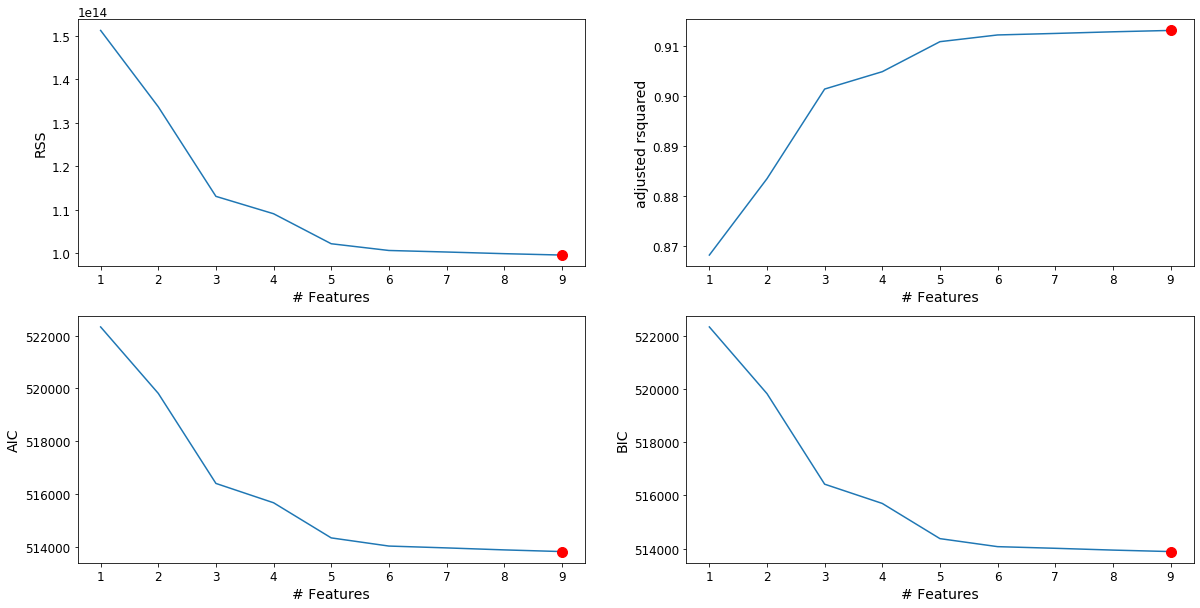

In [69]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the lowest RSS value.
# The argmax() function can be used to identify the location of the minimum point of a vector.
rss = models_best["RSS"]
plt.plot(rss)
plt.plot(rss.argmin(), rss.min(), "or")
plt.xlabel('# Features')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector.

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Features')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Features')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Features')
plt.ylabel('BIC')

# Dimension Reduction Methods

##  Principal Components Analysis (PCA)

Principal Components Analysis (PCA) is a popular approach for deriving a low-dimensional set of features from a large set of features. This reduction dimension method can be performed using the `PCA()` function, which is part of the `sklearn` library. In this lab, we'll apply PCA to the same `housing` data, in order to predict `median house value` (the target variable). When the target variable to predict is continuous, we say that we are in a regression case. The PCA technique for regression is also well-known as "principal components regression". Unfortunately `sklearn` does not have an implementation of PCA and regression combined like the `pls`, package in `R`: https://cran.r-project.org/web/packages/pls/vignettes/pls-manual.pdf so we'll have to do it ourselves.

Let's set up our libraries!

In [71]:
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error

# Some libraries for PCA visualization
import seaborn as sns 
#Make Plotly figure
import chart_studio.plotly as py
# Be aware, plotly may be installed using pip on your shell:
# conda install -c plotly chart-studio
import plotly.graph_objs as go

We'll start by performing Principal Components Analysis (PCA), remembering to scale the data:

In [72]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))
X_reduced.shape

(20433, 13)

In [75]:
X_reduced

array([[-2.37346860e+00,  1.85790191e+00,  2.78777039e+00, ...,
         1.39496969e-01,  8.75578413e-02, -4.30837665e-15],
       [ 2.61047435e+00,  2.71200462e+00,  2.78299656e+00, ...,
         1.22557492e-03, -2.70262221e-01, -1.93264163e-14],
       [-2.25652847e+00,  1.93912701e+00,  2.93702553e+00, ...,
         9.93002549e-02,  6.15814504e-02, -5.42547605e-16],
       ...,
       [-5.57557242e-01,  2.20988735e+00, -1.70177893e+00, ...,
         3.33752538e-01, -1.01099744e-01, -1.77995203e-16],
       [-9.66548540e-01,  2.16014607e+00, -1.67771515e+00, ...,
         3.04409297e-01, -7.24312759e-02, -9.57252613e-17],
       [ 2.67899465e-02,  2.26104754e+00, -1.55755825e+00, ...,
         3.41962513e-01, -2.93096534e-02, -1.15445745e-16]])

Let's print out the first few variables of the first few principal components:

In [74]:
pd.DataFrame(pca.components_.T)
# .loc[:4,:5]


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.101895,-0.515191,-0.276439,0.053254,0.105483,-0.019208,0.410493,-0.083085,-0.047614,0.075004,0.659251,-0.124629,-6.287889e-16
1,-0.099695,0.563630,0.061732,-0.147698,-0.099284,0.015819,-0.331244,0.129869,-0.029487,0.074842,0.700169,-0.115557,-6.091876e-16
2,-0.220290,-0.026235,0.325344,0.106690,0.511219,-0.106170,0.202345,0.720363,-0.023560,0.011303,0.019129,0.004563,8.086003e-17
3,0.477985,0.100817,0.057040,0.012559,-0.073425,0.026993,0.084137,0.137656,-0.283938,0.777675,-0.132290,-0.151348,4.291205e-16
4,0.485053,0.090947,0.041528,0.029162,0.120048,-0.020816,-0.008499,0.026445,-0.390147,-0.289032,0.136190,0.695671,-6.801309e-17
5,0.468911,0.052263,0.039582,-0.003933,0.124223,-0.029476,-0.022796,0.066435,0.854916,0.054002,0.066858,0.127704,3.012130e-17
6,0.486531,0.085181,0.070472,0.027681,0.117804,-0.025526,-0.020524,0.042980,-0.160369,-0.508200,-0.062670,-0.667524,-1.982686e-16
7,0.048074,-0.088668,0.306449,-0.017174,-0.764120,0.189658,0.329624,0.356468,0.064424,-0.177283,0.053128,0.040583,-1.204087e-16
8,0.057193,-0.435589,0.299305,-0.440087,0.013566,-0.020129,-0.389372,0.025307,-0.040566,0.037749,0.046124,-0.007109,-6.046841e-01
9,-0.012104,0.290034,-0.627076,-0.180730,-0.027680,0.013670,0.267004,0.268698,0.019730,-0.072250,-0.133770,0.021000,-5.669735e-01


Now we'll perform 10-fold cross-validation to see how it influences the `MSE`:

[13327277229.959692, 13266400326.451475, 12769747335.401594, 8613264050.278528, 8444284226.544756, 6107425149.229565, 5895457072.4401045, 5704836966.272679, 5298489440.064728, 5021309978.361513, 4844166039.793323, 4739971751.197393, 4727554260.927155, 4727554260.927155]


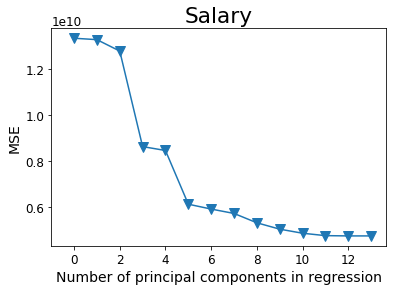

In [76]:
# 10-fold CV, with shuffle
n = len(X_reduced)

kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principal components, adding one component at the time.
for i in np.arange(1, 14):
    score = -1*model_selection.cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

print(mse)

We see that the smallest cross-validation error occurs when $M=12$ components are used. This is barely fewer than $M=13$, which amounts to simply performing least squares, because when all of the components are used in PCA no dimension reduction occurs. However, from the plot we also see that the cross-validation error is roughly the same when only 5 components are included in the model. This suggests that a model that uses just a small number of components might suffice.

We'll print the amount of variance explained by adding each consecutive principal component:

In [77]:
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
#print(pca.explained_variance_ratio_)
#print(pca.singular_values_)

[ 30.2   49.94  62.63  72.29  80.55  88.22  93.7   98.11  99.23  99.69
  99.89 100.   100.  ]


Setting $M=1$ only captures 30.2% of all the variance, or information, in the features. In contrast, using $M=6$ increases the value to 88.22%. Notice that if we were to use all $M=d=13$ components, this would increase to 100% but we won't reduce the dimension!

Now let's perform PCA on the training data and evaluate its test set performance. This process is also helpful to tune the hyper-parameter $M$ and identify the number of components to use:

[13105749882.885128, 13044220161.622173, 12650182837.73411, 8391449544.140944, 8258267780.124899, 5816227090.086492, 5638691030.888273, 5278393462.025439, 5028508641.599117, 4872697597.930478, 4776711061.274555, 4763768373.128659, 4763768373.128659, 4763768373.128659]


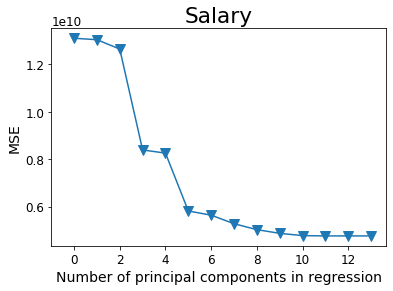

In [78]:
pca2 = PCA()

# Split into training and test sets
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=0.5, random_state=1)

# Scale the data and fit the PCA 
# .fit_transform(X) fit the model with X and apply the dimensionality reduction on X
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)


# 10-fold CV, with shuffle
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)

mse = []

# Compute MSE with only the intercept (no principal components in regression)
#and 10-fold CV is only applied on the train set
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)
#print(mse)


# Compute MSE using CV for the 19 principal components, adding one component at the time
#10-fold CV is only applied on the train set
for i in np.arange(1, 14):
    score = -1*model_selection.cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

print(mse)

We find that the lowest cross-validation error occurs when $M=13$ components are used. However, from the plot we also see that the cross-validation error is roughly the same when only 5 components are included in the model. This suggests again that a model that uses just a small number of components might suffice.
Now, we fix the hyper-parameter $M$ to 5, and we'll see how it performs on the test data and compute the test MSE as follows:

In [79]:
X_reduced_test = pca2.fit_transform(scale(X_test))[:,:5]

#print(X_reduced_test.shape)
#pd.DataFrame(X_reduced_test).info()

# If you want to compare before and after to apply the PCA:
#print(pd.DataFrame(X_reduced_test).describe())
#print(pd.DataFrame(scale(X_test)).describe())

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:5], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
print('The final test MSE is: ',mean_squared_error(y_test, pred))

The final test MSE is:  15932104968.26756


## PCA visualization for $M=5$ components on housing dataset

This part is intended to more visualize PCA using python. We continue to work on the `housing` dataset that has 13 features which we can reduce to $M=5$ (as suggested by the previous part of this lab) by using PCA.

In PCA(), `n_component` specifies how many components are returned after fit and tranformation.

In [80]:
pcamodel = PCA(n_components=5)
pca = pcamodel.fit_transform(scale(X_test))
pca.shape

(10217, 5)

PCA components and their significance can be explained using `explained_variance_ratio_` that is the percentage of variance explained by each of the selected components.

In [81]:
#the percentage of variance explained by each of the selected components
pcamodel.explained_variance_ratio_


array([0.3024185 , 0.1959793 , 0.12589175, 0.09702523, 0.08335494])

Some PCA model attribute plots can help for visualization:

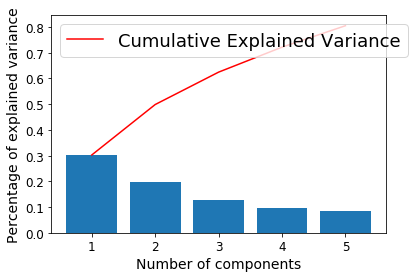

In [82]:
# Explained variance plot
plt.bar(range(1,len(pcamodel.explained_variance_ratio_ )+1),pcamodel.explained_variance_ratio_ )
plt.ylabel('Percentage of explained variance')
plt.xlabel('Number of components')
plt.plot(range(1,len(pcamodel.explained_variance_ratio_ )+1),
         np.cumsum(pcamodel.explained_variance_ratio_ ),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')


Scree plot is the plot of eigen values (explained_variance_) for each of the components.

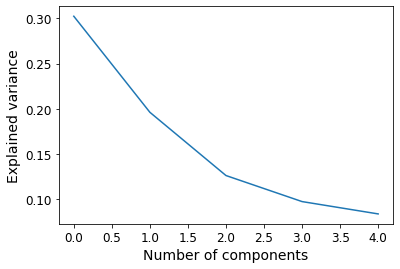

In [83]:
# Scree plot
plt.plot(pcamodel.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()



It can be seen from plots that, two first components explains most of the variance than subsequent components. Here, most of the features are explained and encompassed by the two first components. 

`pca` helds all PCA components (here we fixed the number to 6). First two of them can be visualized using scatter plot.

Text(0.5, 0, 'PCA 1')

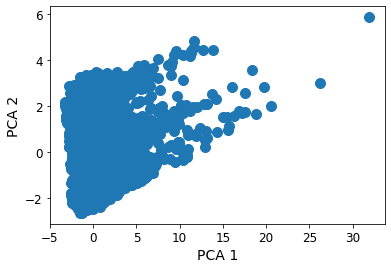

In [84]:
# Scatter plot of PCA1 and PCA2

plt.scatter(pca[:, 0], pca[:, 1])
plt.ylabel('PCA 2')
plt.xlabel('PCA 1')

We can use `Scatter3D` library from `plotly` to plot first 3 components in 3D space. To use this library you need to create your api key [here](https://chart-studio.plotly.com/settings/api#/). Then write your own `username` and `api_key` in the following code:

In [85]:
# 3D Scatter plot of PCA1,PCA2 and PCA3

# Create your api key here: https://chart-studio.plotly.com/settings/api#/
chart_studio.tools.set_credentials_file(username='mtami', api_key='pyKIrlFpmpf5g9c7uuLz')

fig1 = go.Scatter3d(x=pca[:, 0],
                    y=pca[:, 1],
                    z=pca[:, 2],
                    marker=dict(opacity=0.9,
                                reversescale=True,
                                colorscale='Blues',
                                size=5),
                    line=dict (width=0.02),
                    mode='markers')

#Make Plot.ly Layout
mylayout = go.Layout(scene=dict(xaxis=dict( title="PCA1"),
                                yaxis=dict( title="PCA2"),
                                zaxis=dict(title="PCA3")),)

#Plot and save html
py.iplot({"data": [fig1],
                     "layout": mylayout},
                     auto_open=True,
                     filename=("3DPlot.html"))



NameError: name 'chart_studio' is not defined

`components`_ attribute provides principal axes in feature space, representing the directions of maximum variance in the data. This means, we can see influence on each of the components by features.

Text(0.5, 1, 'The effect of features on each components')

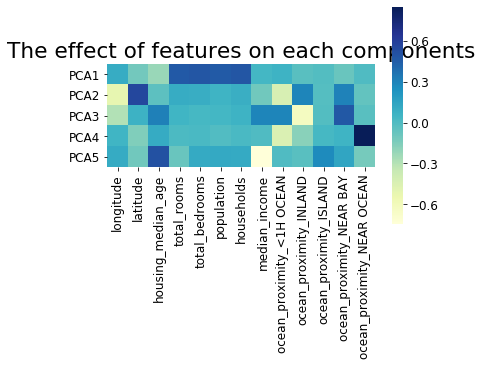

In [86]:
# Effect of variables on each components

ax = sns.heatmap(pcamodel.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(X_test) for X_test in range(1,pcamodel.n_components_+1)],
                 xticklabels=list(X_test.columns),
                 cbar_kws={"orientation": "vertical"})
plt.yticks(rotation=0) 
ax.set_aspect("equal")
plt.title('The effect of features on each components')

Biplot is an interesting plot and contains lot of useful information.

It contains two plots in one:

   + PCA scatter plot which shows first two component ( we already plotted this above)
   + PCA loading plot which shows how strongly each characteristic influences a principal component.

**PCA Loading Plot:** All vectors start at origin and their projected values on components explains how much weight they have on that component. Also , angles between individual vectors tells about correlation between them. 

Let's plot it for our dataset!

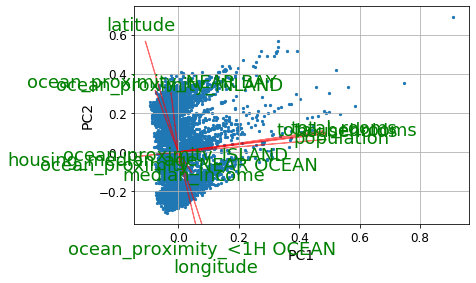

In [87]:
# PCA Biplot

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley,s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

myplot(pca[:,0:2],np.transpose(pcamodel.components_[0:2, :]),list(X_test.columns))
plt.show()


We observe, as sugested by the plot illustrating the effect of features on each components, that the group of features: "total_rooms, total_bedrooms, population, households" is represented by the first component. Then, the group "longitude, latitude, Ocean_proximity_INLAND, Ocean_proximity_NEARBAY" is represented by the second component.
